### Evaluation notebook for trained and saved models

In [27]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=''
import numpy as np
import torch
from torch import nn
from mapsgan import Solver, SGANSolver, cLRSolver, cVAESolver , BicycleGenerator, ToyGenerator, ToyDiscriminator, data_loader
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
from pathlib import Path
import os, glob
import matplotlib.pyplot as plt
from mapsgan.utils import smooth_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=''


In [40]:
experiment = experiments.ETH() # we store filepaths and arguments in here

_ , testloader = data_loader(in_len=8, out_len=12, batch_size=1, num_workers=1, path=experiment.test_dir,
                                  shuffle=False)

In [41]:
model_nicknames = ['toy', 'clr', 'cvae', 'bicy']#, 'sgan_bicy', 'sgan']

In [42]:
model_nickname = model_nicknames[0]
fileprefix = '/fav/*' + model_nickname + '*'
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
filesearch = root_path + '/models' + fileprefix + '*5000*' # can change here acc to saved epoch
filelist = glob.glob(filesearch)
filelist.sort()
filelist
# filename=filelist[0]
# print(filename)
# solver.load_checkpoint(filename)

['/home/yy/ADL4CV/mapsgan/models/fav/toymodel_2_20190205-230617_epoch_5000']

In [43]:
if model_nickname == 'toy':
    generator = ToyGenerator(in_len=8, out_len=12)
    discriminator = ToyDiscriminator()
    solver = Solver(generator, discriminator)
elif model_nickname == 'sgan':
    model_path = '../../sgan/sgan/models/sgan-p-models/'
    model = 'eth_12_model.pt'
    ###
    checkpoint = torch.load(model_path + model, map_location='cpu')
    generator_sgan = get_sgan_generator(checkpoint)
    generator = BicycleGenerator(generator=generator_sgan,
                                 start_mode=mode,
                                 embedding_dim=embedding_dim,
                                 h_dim=decoder_h_dim - 8,
                                 z_dim=8,
                                 in_len=obs_len,
                                 out_len=pred_len,
                                 noise_type=noise_type,
                                 noise_mix_type=noise_mix_type)

    discriminator = TrajectoryDiscriminator(obs_len=8,
                                            pred_len=12,
                                            embedding_dim=16,
                                            h_dim=64,
                                            mlp_dim=64,
                                            num_layers=1,
                                            dropout=0,
                                            batch_norm=0,
                                            d_type='local')
    solver = SGANSolver(generator, discriminator, experiment=experiment, 
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})
else:# bicy or others
    generator = BicycleGenerator(generator=ToyGenerator, start_mode='clr')
    discriminator = ToyDiscriminator()
    solver = cLRSolver(generator, discriminator, 
                optims_args={'generator': {'lr': lr_gen}, 'discriminator': {'lr': lr_dis}})

In [48]:
epochs = solver.load_checkpoint(filelist[0])

### Set these manually according to the script

### Looking at predictions

In [49]:
vis = Visualization()

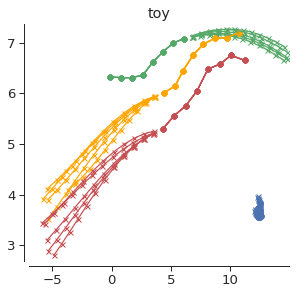

In [52]:
for s in [42]:#[3,25,30,44,65]:
    predictions = solver.sample_distribution(testloader, scene=s, seed=10, z_dim=8, num_samples=5)
    vis.trajectories(predictions, scenes=None, input_truth=True, dist=True, ground_truth=False, title=model_nickname )
    figname = 'dist_' + model_nickname + '.png'
    plt.savefig(figname)
    plt.show()